# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [86]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [87]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

In [88]:
def setup(resolution):
  ##### define domain and mesh ######

  # Define rectangular domain
  L = 4
  H = 2

  # Define circle
  xc = 1.0
  yc = 0.5*H
  rc = 0.2

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0)

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)

  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh (examples with and without a hole in the mesh)
  #resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

 # plt.figure()
 #  plot(mesh)
 # plt.show()


  ##### define FEM spaces #####

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)


  #### define BCs #####

  # Define boundary conditions
  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0)

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  # Examples of time dependent and stationary inflow conditions
  #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
  #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
  uin = 1.0
  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left)
  bcp1 = DirichletBC(Q, pout, dbc_right)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


  return L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin

In [89]:
def solver(nu, L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin, plot):
 ##### define method parameters ####
  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and lienar solvers
  num_nnlin_iter = 5
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

  # Time step length
  dt = 0.5*mesh.hmin()

#### define variational problem ####

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)

  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
  ap = lhs(Fp)
  Lp = rhs(Fp)

#### drag and lift forces ###
  # With  𝜙=(1,0)  we get the drag force  𝐹𝐷 , and with  𝜙=(0,1)  the lift force  𝐹𝐿 .

  # Define the direction of the force to be computed
  phi_x = [1.0, 0.0]
  phi_y = [0.0, 1.0]


  # drag
  psi_expression_D = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x[0], phi_y=phi_y[0], element = V.ufl_element())
  psi_D = interpolate(psi_expression_D, V)
  FD = inner((u1 - u0)/dt + grad(um1)*um1, psi_D)*dx - p1*div(psi_D)*dx + nu*inner(grad(um1), grad(psi_D))*dx

  # lift
  psi_expression_L = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=0, phi_y=1, element = V.ufl_element())
  psi_L = interpolate(psi_expression_L, V)
  FL = inner((u1 - u0)/dt + grad(um1)*um1, psi_L)*dx - p1*div(psi_L)*dx + nu*inner(grad(um1), grad(psi_L))*dx


  # Force normalization
  D = 2*rc
  normalization = -2.0/D

### SOLVER #####
  #### Plotting variables ####
  # Force computation data
  force_array_D = np.array(0.0)
  force_array_D = np.delete(force_array_D, 0)
  force_array_L = np.array(0.0)
  force_array_L = np.delete(force_array_L, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0

  ## saving results
  # Set plot frequency
  plot_time = 0
  plot_freq = 5
  file_u = File("results-NS/u.pvd")
  file_p = File("results-NS/p.pvd")
  !rm results-NS/*


  #### Solver #####
  # Time stepping
  T = 30
  t = dt
  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t)
      #print(s)

      pin.t = t
      #uin.t = t

      # Solve non-linear problem
      k = 0
      while k < num_nnlin_iter:

          # Assemble momentum matrix and vector
          Au = assemble(au)
          bu = assemble(Lu)

          # Compute velocity solution
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(ap)
          bp = assemble(Lp)

          # Compute pressure solution
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)

          # Compute force
          F_D = assemble(FD)
          F_L = assemble(FL)
          if (t > start_sample_time):
            force_array_D = np.append(force_array_D, normalization*F_D)
            force_array_L = np.append(force_array_L, normalization*F_L)
            time = np.append(time, t)

          k += 1

      if plot:

        #s = 'Time t = ' + repr(t)
        #print(s)

        # Save solution to file
        file_u << u1
        file_p << p1
        #plot_time += T/plot_freq


      # Update time step
      u0.assign(u1)
      t += dt

  if plot:
    !tar -czvf results-NS.tar.gz results-NS
    files.download('results-NS.tar.gz')


  return u1, p1, t, force_array_D, force_array_L, time


# **Results**

# **Investigate the flow for different Reynolds number, Re = 1, 10, 100, 1000**

Since we have U = 1, D = 0.4 (diameter of the cylinder), we can vary the viscosity $\nu$ to change Reynolds number $Re = \frac{UD}{\nu}$. We iterate
through a list $\nu = 0.4, 0.04, 0.004, 0.0004$ by defining the variational problem and computing the force for each $\nu$ before solving for the different cases.

In [90]:
# different viscosity Reynold's numbers
nuList = [0.4, 0.04, 0.004, 0.0004] # Re = 1, 10, 100, 1000

# lists to save velocity, forces, times etc for plotting and analysis
results = []
forces = []
strou_force = []
times = []
plot_time = []

# definitions
D1 = 0.4
U = 1.0

for i in nuList:
  print("Computing for nu =", i)

  ### problem setup ####
  L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin = setup(32)

  #### solving for different nu and saving results ####
  nu = i
  velocity, pressure, time, force_array_D, force_array_L, time_array = solver(nu, L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin, plot=0)
  results.append(velocity)
  forces.append(force_array_D)
  forces.append(force_array_L)
  strou_force.append(force_array_L)
  times.append(time)
  plot_time.append(time_array)



Computing for nu = 0.4
rm: cannot remove 'results-NS/*': No such file or directory
Computing for nu = 0.04
rm: cannot remove 'results-NS/*': No such file or directory
Computing for nu = 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Computing for nu = 0.0004
rm: cannot remove 'results-NS/*': No such file or directory


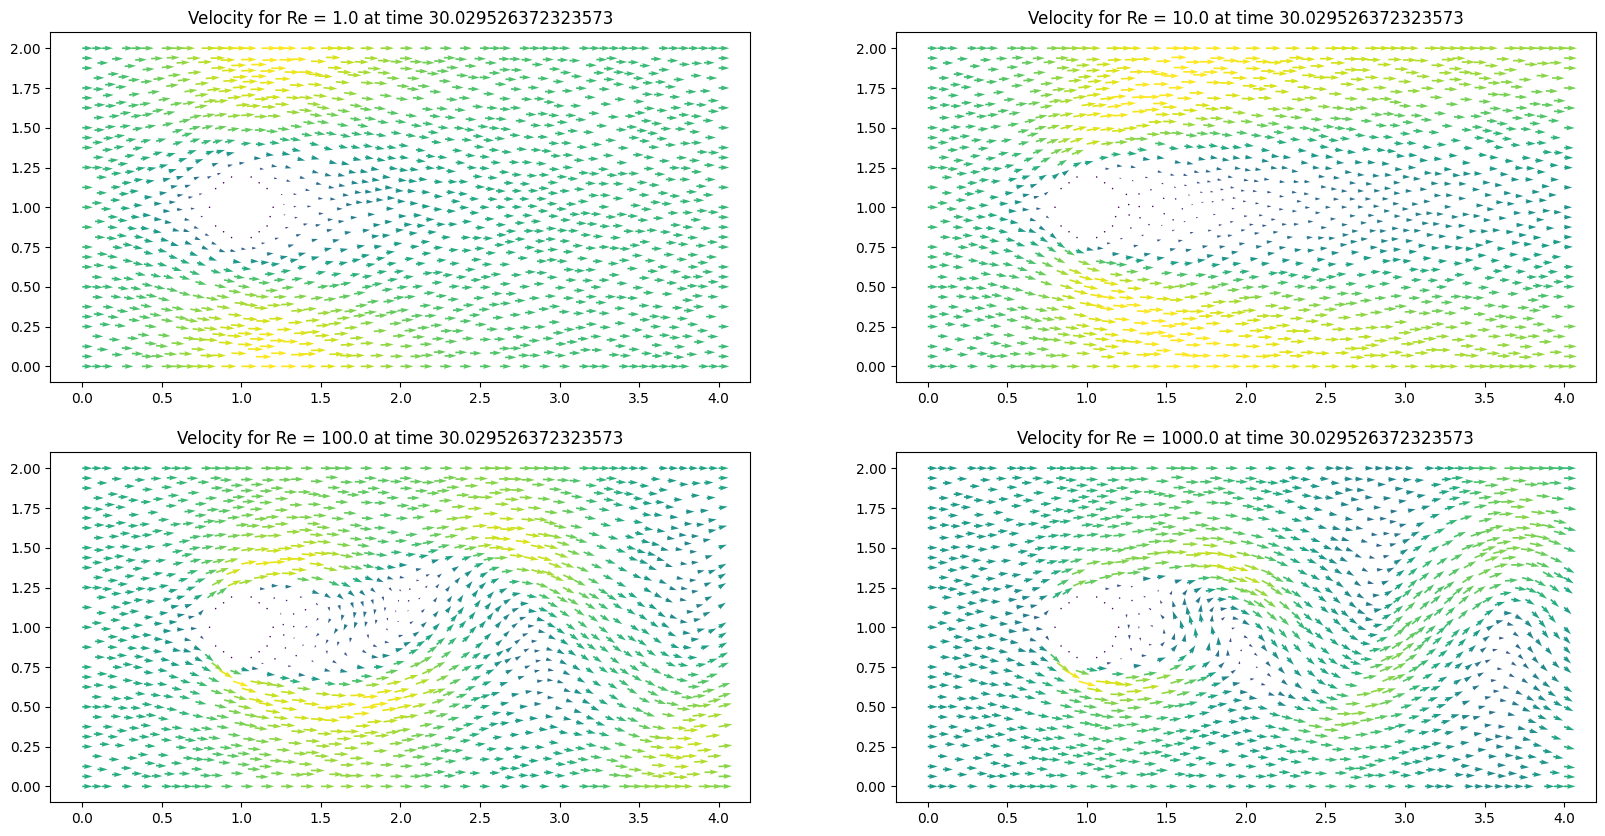

In [91]:
# plotting velocities
plt.figure(figsize=(20,10))
for j in range(4):
  Re = U*D1/nuList[j]
  plt.subplot(2,2,j+1)
  plot(results[j], title = f"Velocity for Re = {Re} at time {times[j]}")

plt.show()

The flow becomes unsteady at Re = 100, 1000 and von Kármán vortex street can be seen starting to develop. The flow is steady for lower Reynolds numbers, Re = 1, 10. These results are expected as a higher Reynolds number increases risk of a flow becoming turbulent.

# Drag and lift coefficients, Strouhal number

**Drag and lift coefficients**

To compute the drag and lift coefficients, we use the definitions
$C_D = \frac{2F_D}{\rho U^2D}$ and $C_L = \frac{2F_L}{\rho U^2D}$, where $F_D$ and $F_L$ are the computed drag and lift forces, $D = 0.4$ is the diameter of the cylinder, $\rho = 1$ is the pressure and $U = 1$ unit velocity.

We can compute the mean drag and lift coefficiens for the four different flows.

In [93]:
# drag and lift coeffients

#𝑐𝐷=2𝐹_𝐷/𝜌𝑈^2𝐷,𝑐𝐿=2𝐹_𝐿/𝜌𝑈^2𝐷

index = 0
Re = [1, 10, 100, 1000]
CD_mean = []
CL_mean = []
CD_list = []
CL_list = []


for k in range(4):
  # computing the coefficients based on the forces from the computation
  CD = 2*forces[index] /(U**2 *D1)
  CL = 2*forces[index+1] / (U**2 * D1)


  # computing mean C_D and C_L for different reynolds numbers
  CD_mean.append(np.mean(CD))
  CL_mean.append(np.mean(CL))
  CD_list.append(CD)
  CL_list.append(CL)

  index += 2



for i, Re in enumerate(Re):
    print(f'Mean CD at Reynolds number {Re}: {CD_mean[i]}')
    print(f'Mean CL at Reynolds number {Re}: {CL_mean[i]}')




Mean CD at Reynolds number 1: 88.57940664213764
Mean CL at Reynolds number 1: 0.18922267211482105
Mean CD at Reynolds number 10: 18.02796101207728
Mean CL at Reynolds number 10: 0.2637522483919498
Mean CD at Reynolds number 100: 8.530069811261287
Mean CL at Reynolds number 100: 0.20219864769975157
Mean CD at Reynolds number 1000: 7.77986238136631
Mean CL at Reynolds number 1000: 0.28327368977499284


The lift coefficients are close to 0 for all Reynolds numbers. For the drag coefficients, an increasing Reynolds number results in a decreasing drag coefficient. Plots of the drag and lift coefficients can be seen below. For higher Reynolds number they can be seen oscillating slightly in a periodic/symmetric manner.

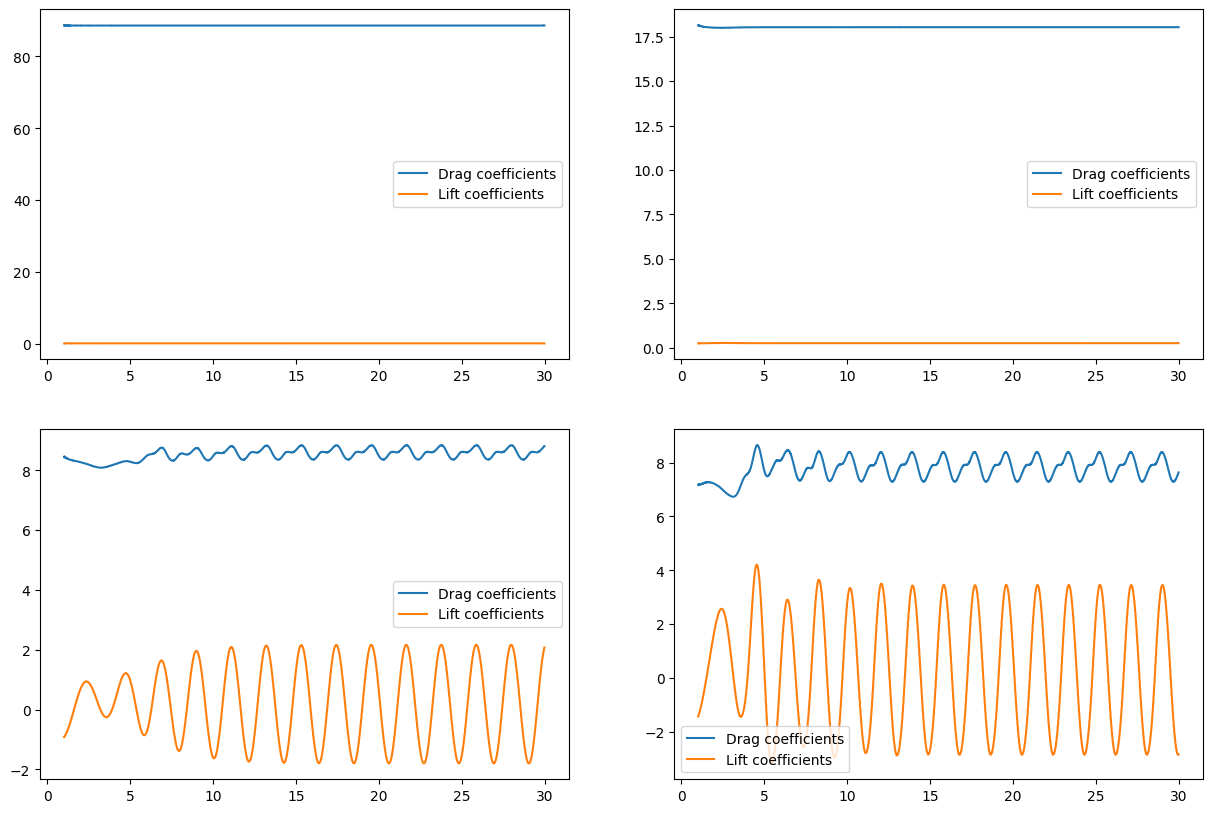

In [94]:

plt.figure(figsize=(15,10))
for k in range(4):
  plt.subplot(2, 2, k+1)
  plt.plot(plot_time[k], CD_list[k], label = "Drag coefficients")
  plt.plot(plot_time[k], CL_list[k], label="Lift coefficients")
  plt.legend()

plt.show()

**Computing Strouhal number for von Kármán vortex street**

We define the Strouhal number as $St = \frac{fD}{U}$, where $f$ is the vortex shedding, $D = 0.4$ is the diameter of the cylinder and $U = 1$ is the unit velocity. We can estimate the vortex shedding frequence by counting the cycles/oscillations in the lift force.

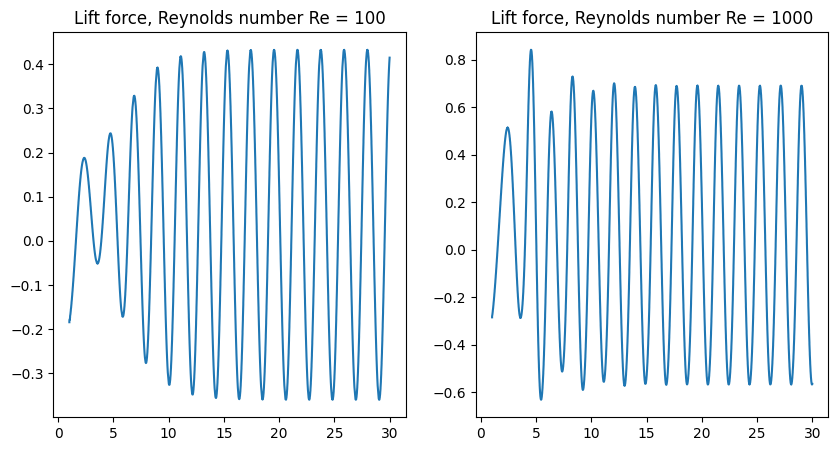

In [95]:
# plotting the lift force for reynolds numbers 100, 1000 to count the vortex shedding
Rey = [100, 1000]
plt.figure(figsize=(10,5))
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.plot(plot_time[i+2], strou_force[i+2])
  plt.title(f"Lift force, Reynolds number Re = {Rey[i]}")


plt.show()

In [96]:
T = 29 # start sampling from time > 1
freq = [13/T, 15/T]

for f in freq:
  St = f*D1/U
  print(St)

0.17931034482758623
0.20689655172413796


For Re = 1000, we have approximately 15 cycles over the time period $T \approx 29$, since we start sampling from time > 1. We can estimate the vortex shedding frequency as $f = \frac{N}{T}$, where $N$ is the number of cycles and $T$ is the time period. We can then compute the Strouhal number for Reynolds number Re = 1000, $St = \frac{\frac{15}{29} \cdot 0.4}{1} \approx 0.206$, and can verify that the von Kármán vortex street has a Strouhal number of $St \approx 0.2$.

# Mesh Resolution


In this assignment, we are comparing the solution for Reynold's number Re = 100 for 3 different mesh resolutions: $h = \frac{1}{8}, \frac{1}{16}, \frac{1}{32}$

We compute three different solutions using the different mesh sizes and compare the plots of velocity, the drag and lift coeffiecients, and the Strouhal number for the simulations.

In [97]:
## variables
nu = 0.004
resolution = [8, 16, 32]
results = []
forces = []
strou_force = []
plot_time = []
D1 = 0.4
U = 1.0

for i in resolution:
  print("resolution =", i)
  ### problem setup different mesh sizes####
  L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin = setup(i)
  #### solving ####
  velocity, pressure, time, force_array_D, force_array_L, time_array = solver(nu, L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin, plot=0)
  results.append(velocity)
  forces.append(force_array_D)
  forces.append(force_array_L)
  strou_force.append(force_array_L)
  plot_time.append(time_array)





resolution = 8
rm: cannot remove 'results-NS/*': No such file or directory
resolution = 16
rm: cannot remove 'results-NS/*': No such file or directory
resolution = 32
rm: cannot remove 'results-NS/*': No such file or directory


**Plotting the velocity**

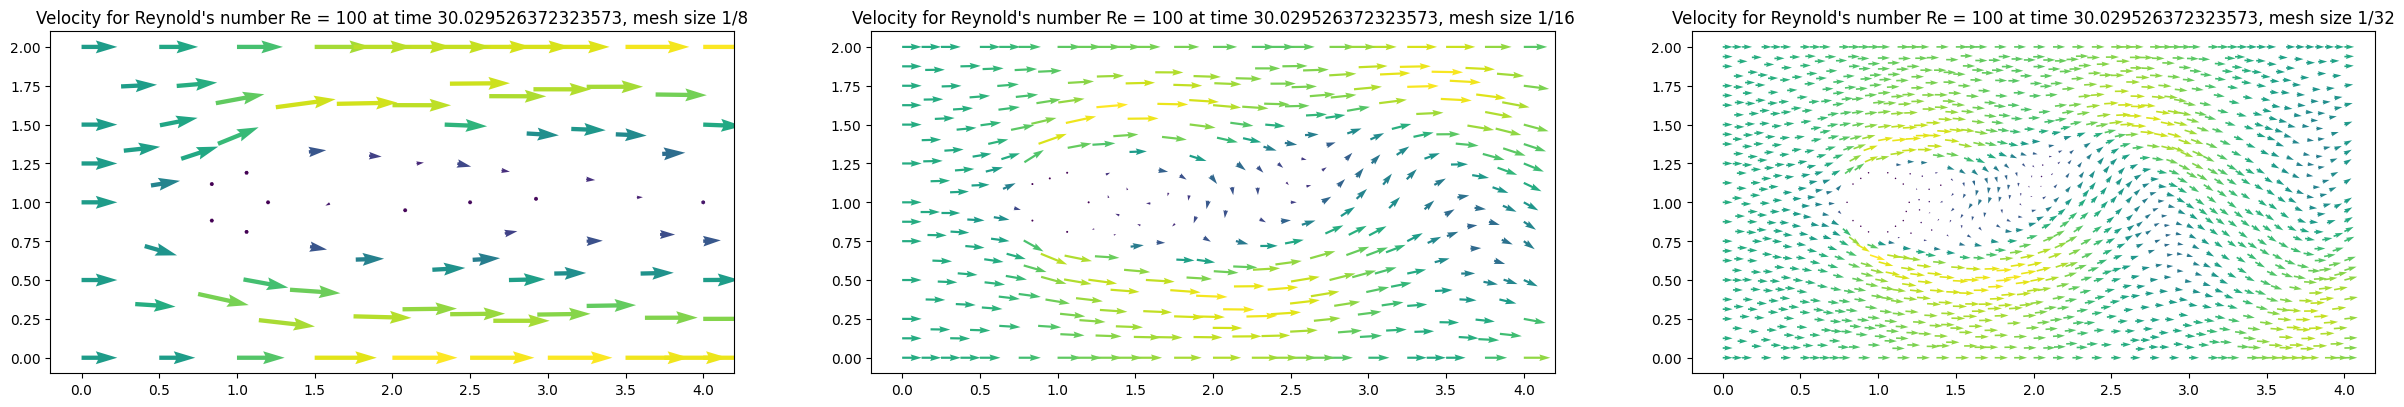

In [98]:
plt.figure(figsize=(30, 30))
for j in range(3):
  ## plots of velocity
  plt.subplot(1,3,j+1)
  Re = U*D1/nuList[j]
  plot(results[j], title=f"Velocity for Reynold's number Re = 100 at time {time}, mesh size 1/{resolution[j]}")

plt.show()

By comparing the plots, we can see that the coarsest mesh is not able to capture the turbulent behavior of the flow and resolve the vortices behind the cylinder. With mesh size $h = \frac{1}{16}$, there is a slight improvement when compared to the coarsest mesh, but not everything is captured that can be seen in the finest mesh.


**Drag and Lift coefficients**

In [101]:
# drag and lift coeffients

#𝑐𝐷=2𝐹_𝐷/𝜌𝑈^2𝐷,𝑐𝐿=2𝐹_𝐿/𝜌𝑈^2𝐷

index = 0
CD_mean = []
CL_mean = []
CD_list = []
CL_list = []

for k in range(3):
  CD = 2*forces[index] /(U**2 *D1)
  CL = 2*forces[index+1] / (U**2 * D1)


  CD_mean.append(np.mean(CD))
  CL_mean.append(np.mean(CL))

  CD_list.append(CD)
  CL_list.append(CL)

  index += 2



for i in range(3):
    print(f'Mean CD at Reynolds number 100: {CD_mean[i]}')
    print(f'Mean CL at Reynolds number 100: {CL_mean[i]}')

Mean CD at Reynolds number 100: 14.942891771027329
Mean CL at Reynolds number 100: -0.2806175500825873
Mean CD at Reynolds number 100: 10.34379471688567
Mean CL at Reynolds number 100: 0.03718924839830371
Mean CD at Reynolds number 100: 8.53006989881135
Mean CL at Reynolds number 100: 0.20219864682548844


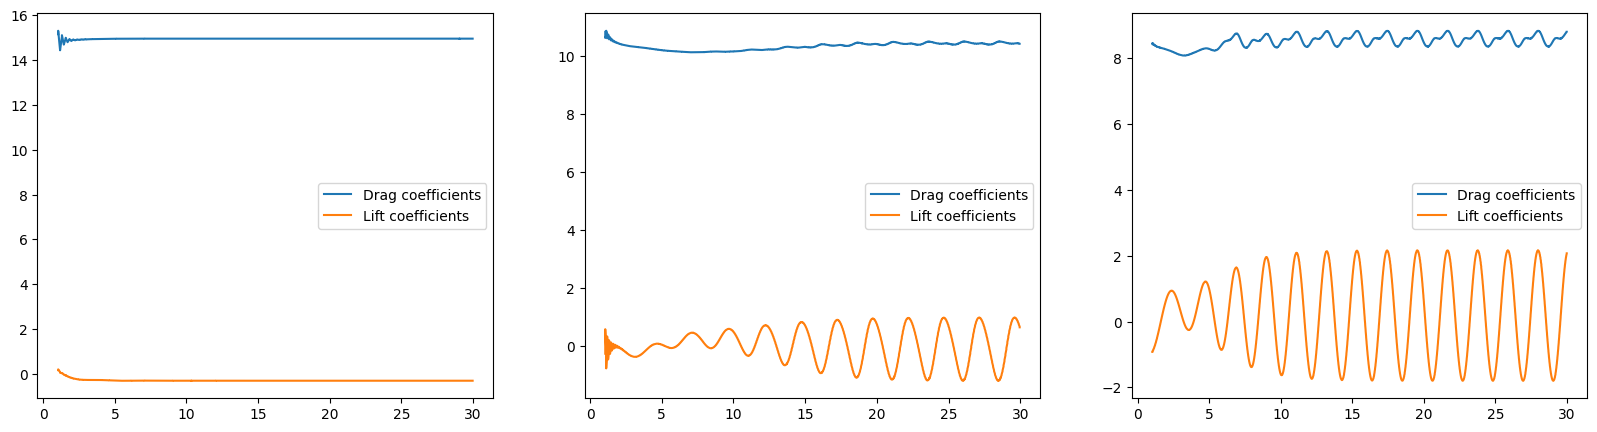

In [105]:

plt.figure(figsize=(20,5))
for k in range(3):
  plt.subplot(1, 3, k+1)
  plt.plot(plot_time[k], CD_list[k], label = "Drag coefficients")
  plt.plot(plot_time[k], CL_list[k], label="Lift coefficients")
  plt.legend()

plt.show()

**Strouhal number**

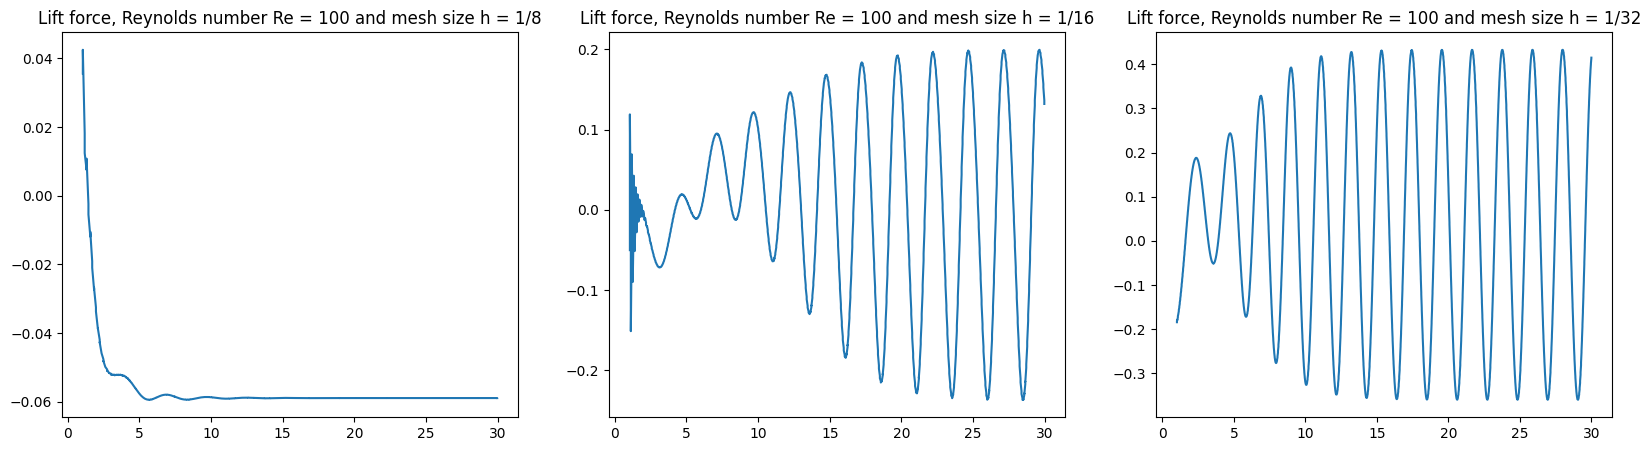

In [106]:
# computing Strouhal number
plt.figure(figsize=(20,5))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.plot(plot_time[i], strou_force[i])
  plt.title(f"Lift force, Reynolds number Re = 100 and mesh size h = 1/{resolution[i]}")
plt.show()

In [107]:
T = 29 # only looking at time > 1
freq = [11/T, 13/T]

for f in freq:
  St = f*D1/U
  print(St)

0.15172413793103448
0.17931034482758623


**Comment on results**

With a coarser mesh, the drag coefficient is overestimated and becomes smaller as the mesh is refined. The lift coefficient is close to 0 but negative for mesh size $h = \frac{1}{8}$, and decreases between $h = \frac{1}{16}$ and $h = \frac{1}{32}$.

It is hard to estimate the vortex shedding frequence for the coarsest mesh since the lift force is not oscillating, but for the 2 refinements the Strouhal number increases as the mesh is refined. To estimate the vortex shedding frequency for $h = \frac{1}{16}$, the first fast oscillations are not counted, since those are not physical and likely due to the mesh size not being fine enough to compute the solution.

In summary, both drag and lift coefficients are overestimated with a coarser mesh, and the Strouhal number is slightly underestimated.

# **Code for creating movie for Re = 100, h = 1/32**

In [108]:
# definitions
#D1 = 0.4
#U = 1.0
#nu = 0.004


### problem setup ####
#L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin = setup(32)

#### solving for different nu and saving results ####
#velocity, pressure, time, force_array_D, force_array_L, time_array = solver(nu, L, H, xc, yc, rc, mesh, V, Q, u, v, p, q, bcu, bcp, pin, plot=1)


# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)


